Generating musical notes using a simple RNN.

Train the model on a collection of piano MIDI files from [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro). Given a sequences of notes, the model will learn to predict the next note in the sequence. Generate a longer sequences of notes by calling the model repeatedly.

# Setup

Use [pretty-midi](https://github.com/craffel/pretty-midi) library to create and parses MIDI files, and [pyfluidsynth](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [1]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 42 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1

In [2]:
!pip install --upgrade pyfluidsynth

In [3]:
!pip install pretty_midi

     |████████████████████████████████| 5.6 MB 4.0 MB/s 
     |████████████████████████████████| 51 kB 8.0 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=b22897889ce64e1b11c02c682da11af21d674b64b407d1a8c5fa31c8c83fbbee
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [4]:
import pathlib
import tensorflow as tf
import glob
import pretty_midi
from IPython import display
import pandas as pd
import collections
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

from typing import Dict, List, Optional, Sequence, Tuple

In [5]:
_SAMPLING_RATE = 16000  # Sampling rate for audio playback

# Download the Maestro dataset

In [6]:
data_dir = pathlib.Path('data/maestro-v2.0.0')

In [7]:
if not data_dir.exists():
    tf.keras.utils.get_file(
        'maestro-v2.0.0-midi.zip',
        origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
        extract=True,
        cache_dir='.', cache_subdir='data')


59252736/59243107 [==============================] - 0s 0us/step


In [8]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('The number of files:', len(filenames))

The number of files: 1282


In [9]:
filenames

['data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--1.midi',
 'data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--5.midi',
 'data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_13_R1_2014_wav--1.midi',
 'data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--2.midi',
 'data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--3.midi',
 'data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--5.midi',
 'data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_07_R1_2014_wav--7.midi',
 'data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--2.midi',
 'data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_22_R1_2014_wav--1.midi',
 'data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--8.midi',
 'data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_04-07-08-10-12-1

# Process a MIDI file

Use `pretty_midi` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on the computer, you can do so in colab by writing `files.download(sample_file)`.

In [10]:
sample_file = filenames[9]
print(sample_file)

data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--8.midi


Generate a `PrettyMIDI` object for the sample MIDI file.

In [11]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. The playback widget may take several seconds to load.

In [12]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [13]:
display_audio(pm)

Do some inspection on the MIDI file. What kind of instruments are used?

In [14]:
pm.instruments

[Instrument(program=0, is_drum=False, name="06.29  4~5 e-Comp")]

In [15]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
instrument_name

Number of instruments: 1


'Acoustic Grand Piano'

In [16]:
instrument.notes

[Note(start=1.000000, end=2.083333, pitch=37, velocity=29),
 Note(start=1.557292, end=2.226562, pitch=49, velocity=32),
 Note(start=1.967448, end=2.614583, pitch=40, velocity=42),
 Note(start=2.372396, end=3.113281, pitch=37, velocity=37),
 Note(start=2.730469, end=3.233073, pitch=49, velocity=27),
 Note(start=3.029948, end=3.638021, pitch=40, velocity=40),
 Note(start=3.389323, end=4.076823, pitch=37, velocity=27),
 Note(start=3.710938, end=4.162760, pitch=49, velocity=26),
 Note(start=4.307292, end=4.457031, pitch=52, velocity=33),
 Note(start=4.014323, end=4.546875, pitch=40, velocity=34),
 Note(start=4.503906, end=4.609375, pitch=57, velocity=38),
 Note(start=4.638021, end=4.714844, pitch=64, velocity=44),
 Note(start=4.781250, end=4.891927, pitch=57, velocity=45),
 Note(start=4.304688, end=4.971354, pitch=37, velocity=28),
 Note(start=4.912760, end=5.000000, pitch=61, velocity=53),
 Note(start=5.037760, end=5.095052, pitch=69, velocity=53),
 Note(start=4.667969, end=5.136719, pitc

# Extract notes

In [17]:
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f'{i}: pitch={note.pitch}, note_name={note_name}, '
          f'duration={duration:.4f}')

0: pitch=37, note_name=C#2, duration=1.0833
1: pitch=49, note_name=C#3, duration=0.6693
2: pitch=40, note_name=E2, duration=0.6471
3: pitch=37, note_name=C#2, duration=0.7409
4: pitch=49, note_name=C#3, duration=0.5026
5: pitch=40, note_name=E2, duration=0.6081
6: pitch=37, note_name=C#2, duration=0.6875
7: pitch=49, note_name=C#3, duration=0.4518
8: pitch=52, note_name=E3, duration=0.1497
9: pitch=40, note_name=E2, duration=0.5326


Use 3 three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number. The `step` is the time elapsed from the previous note or start of the track. The `duration` is how long the note will be playing in seconds and is difference between the note end and note start times.

Extract the notes from the sample MIDI file.

In [18]:
def midi_to_notes(midi_file:str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start-prev_start)
        notes['duration'].append(end-start)
        prev_start = start
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})
  

In [19]:
raw_notes = midi_to_notes(sample_file)
raw_notes[:10]

,pitch,start,end,step,duration
0,37,1.000000,2.083333,0.000000,1.083333
1,49,1.557292,2.226562,0.557292,0.669271
2,40,1.967448,2.614583,0.410156,0.647135
3,37,2.372396,3.113281,0.404948,0.740885
4,49,2.730469,3.233073,0.358073,0.502604
5,40,3.029948,3.638021,0.299479,0.608073
6,37,3.389323,4.076823,0.359375,0.687500
7,49,3.710938,4.162760,0.321615,0.451823
8,40,4.014323,4.546875,0.303385,0.532552
9,37,4.304688,4.971354,0.290365,0.666667


It may be easier to interpret the note names rather than the pitches, so you can use the function below to covert from the numeric pitch values to note names. The note name shows the type of note, accidental and octave number (e.g. C#4)


In [20]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C#2', 'C#3', 'E2', 'C#2', 'C#3', 'E2', 'C#2', 'C#3', 'E2', 'C#2'],
      dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes.

In [21]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])

    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(
        plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker="."
    )
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

Plot the notes for the entire track

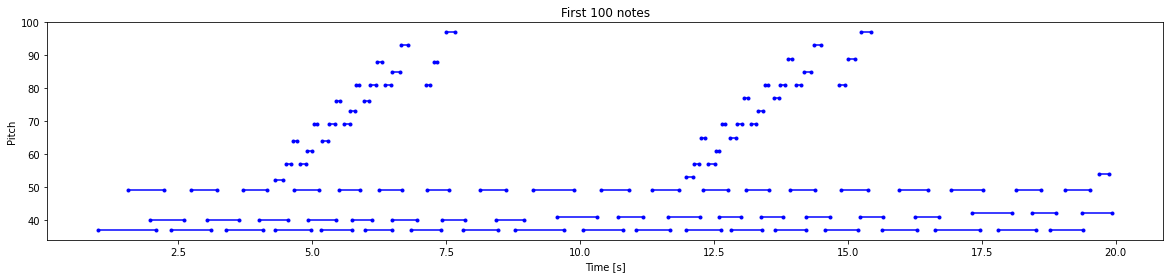

In [22]:
plot_piano_roll(raw_notes, count=100)

Check the distribution of each note variable.

In [23]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

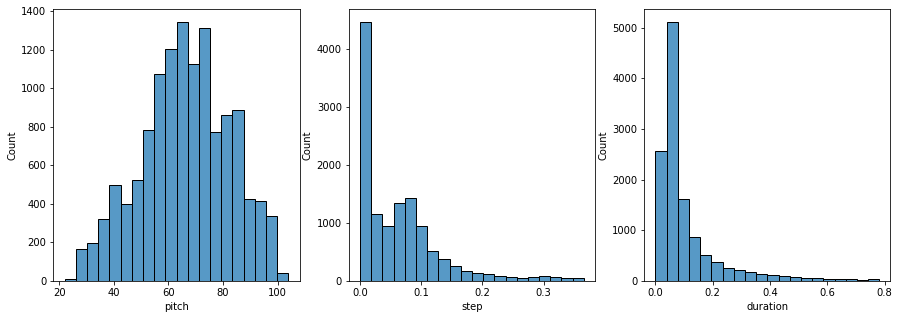

In [24]:
plot_distributions(raw_notes)

# Create a MIDI file

Generate your own MIDI file from a list of notes using the function below:

In [25]:
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str, velocity: int=100,) -> pretty_midi.PrettyMIDI:
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))
    prev_start = 0
    for i, note in notes.iterrows():
      start = float(prev_start + note['step'])
      end = float(start + note['duration'])
      note = pretty_midi.Note(
          velocity=velocity,
          pitch=int(note['pitch']),
          start=start,
          end=end,
      )
      instrument.notes.append(note)
      prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [26]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [27]:
display_audio(example_pm)

Can write `files.download(example_file)` to download and play this file

# Creating the training dataset

Creating the training set by extracting notes from MIDI files. You can start by using small number of files, and experiment later with more. This may take a couple of minutes.

In [28]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)



In [29]:
n_notes = len(all_notes)
print('The number of notes parsed: ', n_notes)

The number of notes parsed:  25650


Create a tf.data.Dataset from the parsed notes

In [30]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)


In [31]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

We will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and next note as the label. In this way, the model will be trained to predict the next note in a sequence.

We can use window function with size `seq_length` to create the features and labels in this format

In [32]:
def create_sequences(dataset: tf.data.Dataset, seq_length: int, vocab_size = 128,) -> tf.data.Dataset:
    """
    Returns TF dataset of sequence and label examples.
    """

    seq_length = seq_length + 1
    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)

    # `flat_map` flattens the "dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize more pitch
    def scale_pitch(x):
        x = x / [vocab_size, 1.0, 1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key: labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels
    
    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence lenght for each example. 

Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use hyperparameter tuning. The size of vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`

In [33]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of dataset is `(100, 1)`, meaning that the model wil take 100 notes as input, and learn to predict the following note as output.

In [34]:
for seq, target in seq_ds.take(1):
    print('Sequence shape: ', seq.shape)
    print('Sequence elements (first 10): ', seq[:10])
    print()
    print('Targe: ', target)


Sequence shape:  (25, 3)
Sequence elements (first 10):  tf.Tensor(
[[0.6796875  0.         0.24088542]
 [0.671875   0.18489583 0.11458333]
 [0.65625    0.1171875  0.09765625]
 [0.640625   0.09244792 0.10416667]
 [0.6328125  0.07421875 0.07161458]
 [0.6171875  0.078125   0.1015625 ]
 [0.609375   0.08463542 0.09244792]
 [0.5859375  0.06380208 0.1015625 ]
 [0.578125   0.09244792 0.03255208]
 [0.5625     0.03645833 0.09895833]], shape=(10, 3), dtype=float64)

Targe:  {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=54.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.07421875>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=1.4921875>}


Batch the examples, and configure the dataset for performance

In [35]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [36]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

# Develop model

The model will have three outputs, one for each note variable. For `pitch` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [37]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [38]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

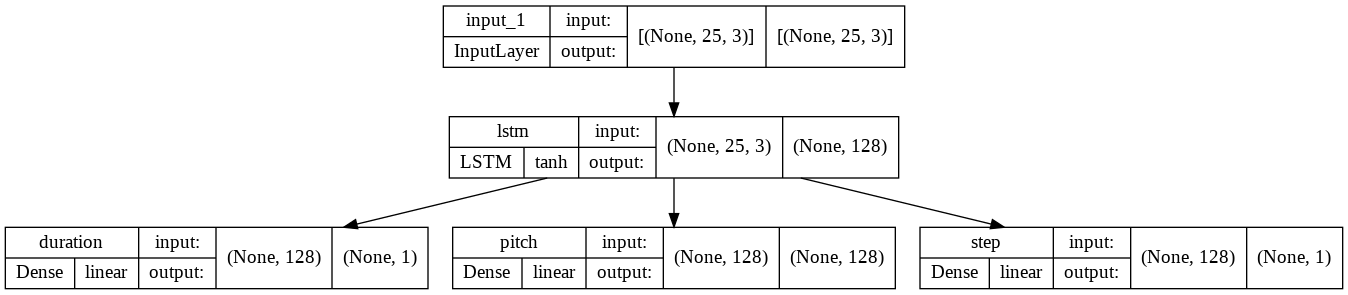

In [64]:
tf.keras.utils.plot_model(model,
                          to_file='/content/drive/MyDrive/music-generator/images/model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          show_layer_activations=True)

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses. 
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [39]:
losses = model.evaluate(train_ds, return_dict=True)
losses

400/400 [==============================] - 8s 5ms/step - loss: 5.1172 - duration_loss: 0.2064 - pitch_loss: 4.8564 - step_loss: 0.0544


{'duration_loss': 0.20637394487857819,
 'loss': 5.117241382598877,
 'pitch_loss': 4.856419086456299,
 'step_loss': 0.05444788560271263}

In [40]:
model.compile(loss=loss,
              loss_weights={
                  'pitch': 0.05, 
                  'step': 1.0,
                  'duration': 1.0,
              },
              optimizer=optimizer)

The `loss` then becomes the weighted sum of the individual losses. 

In [41]:
model.evaluate(train_ds, return_dict=True)

400/400 [==============================] - 2s 4ms/step - loss: 0.5036 - duration_loss: 0.2064 - pitch_loss: 4.8564 - step_loss: 0.0544


{'duration_loss': 0.20637394487857819,
 'loss': 0.5036427974700928,
 'pitch_loss': 4.856419086456299,
 'step_loss': 0.05444788560271263}

Train the model.

In [42]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/music-generator/models/checkpoints/training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [53]:
%%time
epochs = 100
history = model.fit(train_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/100
400/400 [==============================] - 2s 5ms/step - loss: 0.2017 - duration_loss: 0.0220 - pitch_loss: 3.3371 - step_loss: 0.0128
Epoch 2/100
400/400 [==============================] - 2s 6ms/step - loss: 0.1996 - duration_loss: 0.0210 - pitch_loss: 3.3145 - step_loss: 0.0129
Epoch 3/100
400/400 [==============================] - 4s 10ms/step - loss: 0.1954 - duration_loss: 0.0197 - pitch_loss: 3.2922 - step_loss: 0.0111
Epoch 4/100
400/400 [==============================] - 3s 9ms/step - loss: 0.1937 - duration_loss: 0.0190 - pitch_loss: 3.2772 - step_loss: 0.0108
Epoch 5/100
400/400 [==============================] - 3s 8ms/step - loss: 0.1955 - duration_loss: 0.0206 - pitch_loss: 3.2734 - step_loss: 0.0113
Epoch 6/100
400/400 [==============================] - 2s 5ms/step - loss: 0.1955 - duration_loss: 0.0207 - pitch_loss: 3.2718 - step_loss: 0.0112
Epoch 7/100
400/400 [==============================] - 2s 5ms/step - loss: 0.1928 - duration_loss: 0.0193 - pitch_los

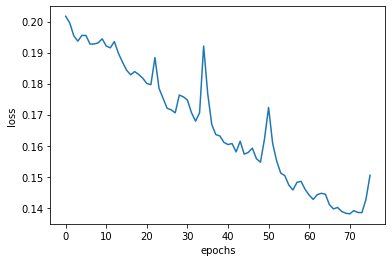

In [54]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes. 

For note pitch, it draws a sample from softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The `temperature` parameter can be used to control the randomness of notes generated.

In [55]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [56]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [57]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,38,0.044115,0.209682,0.044115,0.253797
1,98,0.114996,0.546116,0.159111,0.705228
2,95,0.138708,0.559754,0.297819,0.857573
3,98,0.140350,0.429425,0.438169,0.867593
4,50,0.138547,0.437426,0.576716,1.014142
5,98,0.136825,0.306371,0.713541,1.019911
6,95,0.127634,0.288476,0.841175,1.129650
7,54,0.075933,0.179821,0.917108,1.096929
8,54,0.088247,0.174004,1.005355,1.179359
9,98,0.087625,0.142478,1.092980,1.235459


In [58]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [60]:
# Download file
#from google.colab import files
#files.download(out_file)

Visualize the generated notes.

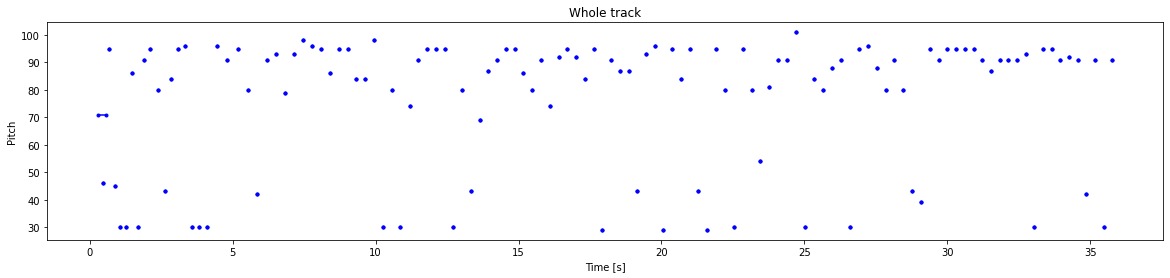

In [49]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

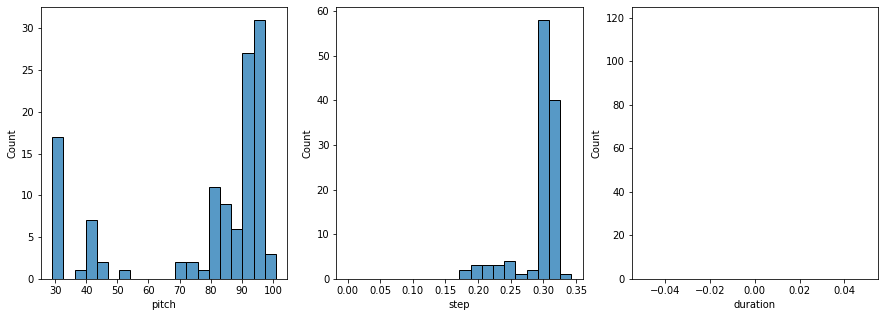

In [50]:
plot_distributions(generated_notes)

Notice the change in distribution of the note variables. Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of ouputs to reduce the loss. This is particulary revelant for `step` and `duration`, which has uses MSE loss. For `pitch`, we can increase the randomness by increasing the `temperature` in `predict_next_note`.